In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [4]:
names = ["num", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/WISDM.csv", header=None, names=names, comment=";")
df = df.drop('num', axis=1)
df.shape
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1048570,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048571,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048572,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000
1048573,7,Standing,2.091660e+14,-7.930000,5.600000,-1.180000


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953,1
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424,1
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722,1
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717,1
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1048570,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000,5
1048571,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000,5
1048572,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000,5
1048573,7,Standing,2.091660e+14,-7.930000,5.600000,-1.180000,5


/tmp/ipython-input-1513145454.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['ActivityEncoded'], sort = True)


NameError: name 'LABELS' is not defined

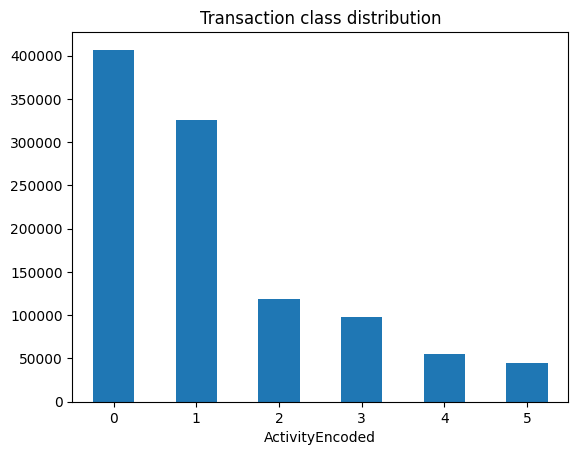

In [6]:
count_classes = pd.value_counts(df['ActivityEncoded'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("ActivityEncoded")
plt.ylabel("Frequency");

In [7]:
frauds = df[df.ActivityEncoded == 1]
normal = df[df.ActivityEncoded == 0]
frauds.shape

(325975, 7)

In [8]:
normal.shape

(406775, 7)

In [9]:
df['Class'] = (df['activity'] == 'Sitting').astype(int)

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

print("Sitting(이상치) 개수:", frauds.shape[0])
print("Normal(정상) 개수:", normal.shape[0])

Sitting(이상치) 개수: 54876
Normal(정상) 개수: 993699


In [10]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['timestamp'], axis=1)

scaler = StandardScaler()
data[['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(
    data[['x_axis', 'y_axis', 'z_axis']]
)

data.head()

,user_id,activity,x_axis,y_axis,z_axis,ActivityEncoded,Class
0,33,Jogging,-0.221614,0.792210,0.015937,1,0
1,33,Jogging,0.625987,0.580504,0.109693,1,0
2,33,Jogging,0.609804,0.523506,-0.106230,1,0
3,33,Jogging,-0.209476,1.661425,0.541539,1,0
4,33,Jogging,-0.294439,0.706713,1.413753,1,0


In [11]:
RANDOM_SEED = 42

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]

y_test = X_test['Class']

drop_cols = ['user_id', 'activity', 'ActivityEncoded', 'Class']

X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

X_train = X_train.values
X_test = X_test.values

X_train.shape, X_test.shape

((794950, 3), (209715, 3))

In [13]:
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim,))

encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)

decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # credit과 동일하게 sigmoid

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1429 - val_loss: 1.0104
Epoch 2/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.0070 - val_loss: 0.9920
Epoch 3/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9930 - val_loss: 0.9885
Epoch 4/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9887 - val_loss: 0.9875
Epoch 5/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9865 - val_loss: 0.9871
Epoch 6/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9884 - val_loss: 0.9870
Epoch 7/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9866 - val_loss: 0.9869
Epoch 8/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.9870 - val_loss: 0.9869
Epoch 9/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9847 - val_loss: 0.9869
Epoch 10/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9882 - val_loss: 0.9869
Epoch 11/50
2795/2795 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9888 - val_loss: 0.9869
Epoch 12/50
2795/2795 ━━━━━━━━

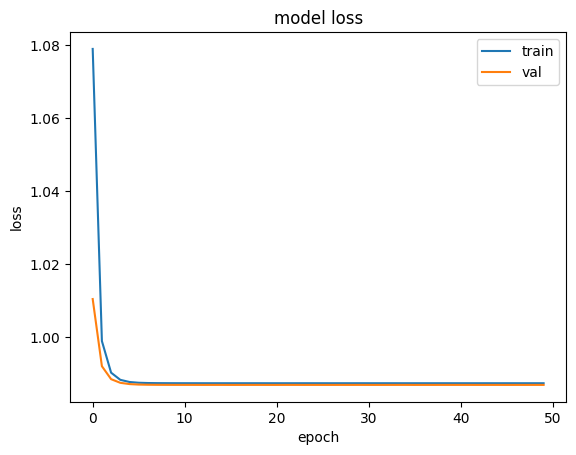

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test.values
})

error_df.describe()

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


,reconstruction_error,true_class
count,209715.000000,209715.000000
mean,1.002617,0.052290
std,1.220944,0.222612
min,0.000118,0.000000
25%,0.214769,0.000000
50%,0.552421,0.000000
75%,1.290047,0.000000
max,12.697332,1.000000


Threshold: 0.5


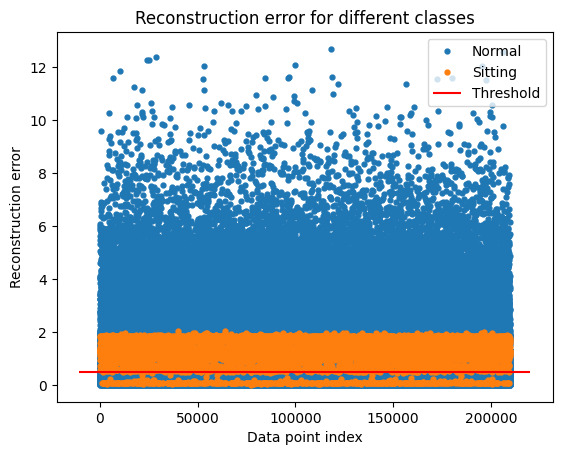

In [17]:
threshold = 0.5
print("Threshold:", threshold)

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(
        group.index, group.reconstruction_error,
        marker='o', ms=3.5, linestyle='',
        label='Sitting' if name == 1 else 'Normal'
    )

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1],
          colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

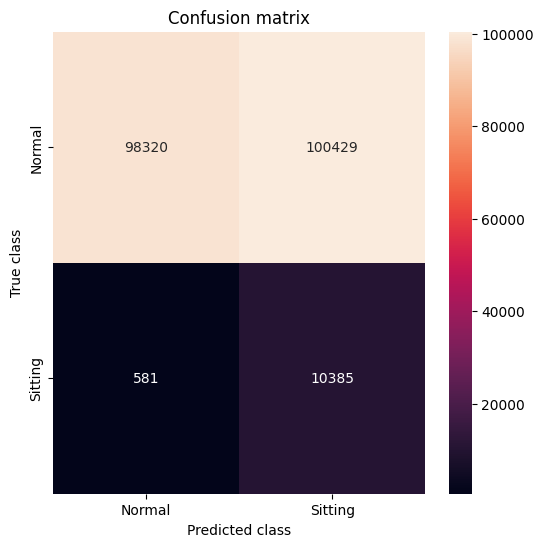

              precision    recall  f1-score   support

      Normal       0.99      0.49      0.66    198749
     Sitting       0.09      0.95      0.17     10966

    accuracy                           0.52    209715
   macro avg       0.54      0.72      0.42    209715
weighted avg       0.95      0.52      0.64    209715



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix,
            xticklabels=['Normal', 'Sitting'],
            yticklabels=['Normal', 'Sitting'],
            annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred,
                            target_names=['Normal', 'Sitting']))